## Unsupervised Behavioral Phenotyping with 3D Skeletal Pose
Joshua Wu

Timothy Dunn Lab

14 October 2022

Neurodegenerative diseases (like Parkinson's) are characterized by a wide variety of behavioral defects or movement deficits. However, behavior and movement have historically been difficult to quantify and measure. Recent developments in hardware and machine learning have enabled more objective behavioral metrics by providing continuous 3D measurements of naturalistic animal behavior through multi-view videos. These new modalities of data offer a means by which we can comprehensively characterize behavioral phenotypes of neural (dys)-function. We present `dappy` to establish an open-source API with easy access to machine learning methods for the analysis of 3D pose sequences.

This notebook implements a Python version of [CAPTURE (Marshall, 2020)](https://www.cell.com/neuron/fulltext/S0896-6273(20)30894-1?_returnURL=https%3A%2F%2Flinkinghub.elsevier.com%2Fretrieve%2Fpii%2FS0896627320308941%3Fshowall%3Dtrue), which was based on earlier work [MotionMapper (Berman, 2014)](https://royalsocietypublishing.org/doi/full/10.1098/rsif.2014.0672) for the analysis of behavioral data, which can interface with future frameworks.

First, we import the necessary modules.

In [5]:
from dappy import features, read, write
import dappy.DataStruct as ds
import dappy.visualization as vis
import numpy as np
import time
from IPython.display import Video
from dappy.embed import Watershed, Embed
%matplotlib inline

Load pose predictions and keypoint connectivity information

In [6]:
analysis_key = "tutorial"
config = read.config("../../configs/" + analysis_key + ".yaml")

pose, ids = read.pose_h5(config["data_path"] + "pose_aligned.h5")

connectivity = read.connectivity(
    path=config["skeleton_path"], skeleton_name=config["skeleton_name"]
)

meta, meta_by_frame = read.meta(config["meta_path"], id=ids)

Plot some skeletons together

  0%|          | 0/200 [00:00<?, ?it/s]


ValueError: array([3.       , 1.5651001, 0.       , 1.5      ], dtype=float32) is not a valid value for color

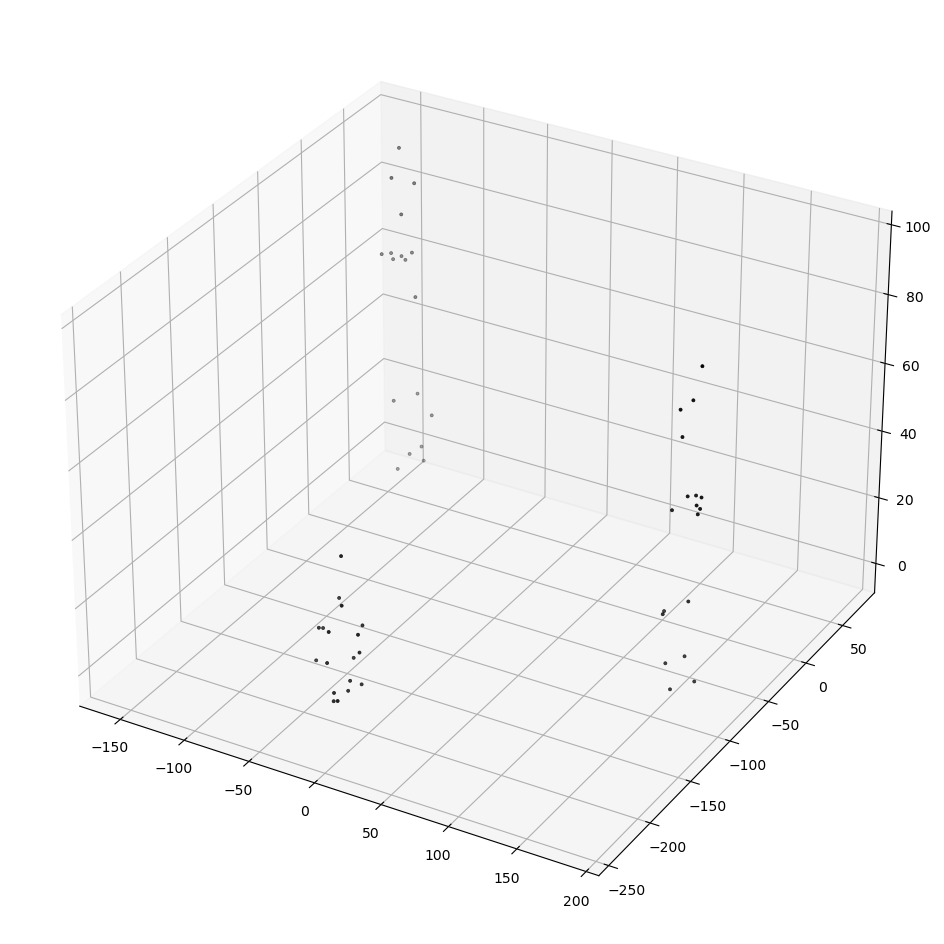

In [7]:
vis.skeleton_vid3D(
    pose,
    connectivity,
    frames=[1000, 500000, 200000],
    N_FRAMES=200,
    dpi=100,
    VID_NAME="vid_raw.mp4",
    SAVE_ROOT=config["out_path"],
)

Video(config["out_path"] + "vis_vid_raw.mp4", width=600, height=600)

All other features will be egocentric so we will center and lock the front spine onto the x-z axis by rotation.

In [ ]:
pose = features.rotate_spine(features.center_spine(pose))

vis.skeleton_vid3D(
    pose,
    connectivity,
    frames=[50000],
    N_FRAMES=200,
    dpi=100,
    VID_NAME="vid_centered.mp4",
    SAVE_ROOT=config["out_path"],
)

In [ ]:
Video(config["out_path"] + "vis_vid_centered.mp4", width=600, height=600)

Using this centered and spine-locked pose transformation, we can calculate relative velocities of all keypoints. We leave out the mid spine since it is zeroed.

In [ ]:
# Getting relative velocities
rel_vel, rel_vel_labels = features.get_velocities(
    pose,
    ids,
    connectivity.joint_names,
    joints=np.delete(np.arange(18), 4),
    widths=[5, 11, 51],
)

Next, we calculate joint angles.

Hopefully, informative joint angles are preselected in `skeletons.py`.

In [ ]:
# Calculating joint angles
angles, angle_labels = features.get_angles(pose, connectivity.angles)

Finally, we are going to save the egocentric x, y, z coordinates as its own set of features

This code does not calculate anything - it just reshapes the pose and generates labels for each feature.

In [ ]:
# Reshape pose to get egocentric pose features
ego_pose, ego_pose_labels = features.get_ego_pose(pose, connectivity.joint_names)

Merge features together and clear some memory

In [ ]:
# Collect all features together
features = np.concatenate([ego_pose, angles], axis=1)
labels = ego_pose_labels + angle_labels

In [ ]:
# Save or read kinematic/wavelet features from h5 file
write.features_h5(
    features, labels, path="".join([config["out_path"], "postural_feats.h5"])
)
# features, labels =  read_h5(path = ''.join([pstruct.out_path,'postural_feats.h5']))

It's now time for principal component analysis (PCA). PCA is a dimensionality reduction technique which generates orthogonal axes of high variance upon which to project our data. There are many implementations of PCA, but we will use Facebook's Fast Randomized PCA package (`fbpca`), which is significantly faster than most other implementations.

We calculate PCA separately on each feature category to preserve variance and balance the categories. This is in lieu of z-transforming (mean-centering and unit variance) every feature. ** Discussion

In [ ]:
t = time.time()
pc_feats, pc_labels = features.pca(
    features, labels, categories=["ego_euc", "ang"], n_pcs=5, method="fbpca"
)
print("PCA time: " + str(time.time() - t))

del features, labels

In [ ]:
wlet_feats, wlet_labels = features.wavelet(
    pc_feats, pc_labels, ids, sample_freq=90, freq=np.linspace(1, 25, 25), w0=5
)

We now use PCA to reduce the dimensions of the new wavelet features, and consolidate with previous PC scores.

In [ ]:
pc_wlet, pc_wlet_labels = features.pca(
    wlet_feats,
    wlet_labels,
    categories=["wlet_ego_euc", "wlet_ang"],
    n_pcs=5,
    method="fbpca",
)
del wlet_feats, wlet_labels
pc_feats = np.hstack((pc_feats, pc_wlet))
pc_labels += pc_wlet_labels
del pc_wlet, pc_wlet_labels

In [ ]:
write.features_h5(
    pc_feats, pc_labels, path="".join([config["out_path"], "pca_feats.h5"])
)

In [ ]:
data_obj = ds.DataStruct(
    pose=pose,
    id=ids,
    id_full=ids,
    meta=meta,
    meta_by_frame=meta_by_frame,
    connectivity=connectivity,
)

data_obj.features = pc_feats
data_obj = data_obj[:: config["downsample"], :]

In [ ]:
# Embedding using fitsne
embedder = Embed(
    embed_method=config["single_embed"]["method"],
    perplexity=config["single_embed"]["perplexity"],
    lr=config["single_embed"]["lr"],
)
data_obj.embed_vals = embedder.embed(data_obj.features, save_self=True)

In [ ]:
# Watershed clustering
data_obj.ws = Watershed(
    sigma=config["single_embed"]["sigma"], max_clip=1, log_out=True, pad_factor=0.05
)
data_obj.data.loc[:, "Cluster"] = data_obj.ws.fit_predict(data=data_obj.embed_vals)

In [ ]:
vis.density(
    data_obj.ws.density,
    data_obj.ws.borders,
    filepath="".join([config["out_path"], config["label"], "/density.png"]),
    show=True,
)

In [ ]:
vis.density_cat(
    data=data_obj,
    column='id',
    watershed=data_obj.ws,
    n_col=4,
    filepath="".join(
        [config["out_path"], config["label"], "/density_id.png"]
    ),
    show=True
)

Time to run the rest of the analysis